# Predicting solubility

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# for pipeline
from sklearn.pipeline import Pipeline

# for feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# for pre-processing data
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# for performance evaluation
from sklearn.metrics import mean_squared_error, r2_score

# for building regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# visualize trees
from sklearn.tree import export_graphviz

## Loading and splitting data

In [2]:
# import dataset being used
df = pd.read_csv('aqsoldb.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

In [4]:
X = df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8]], axis=1)

In [5]:
# creating y matrix from Solubility values
y = df['Solubility']

In [6]:
# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

## Constant variables for each run

In [7]:
# list of regressors that are going to be compared
regressors = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), SVR()]

In [8]:
# creating transformer which will carry out Yeo-Johnson transformation and also standardize the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [13]:
# select top features based on mutual_info_regression
selector = SelectKBest(mutual_info_regression)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumValenceElectrons',
       'NumAromaticRings', 'RingCount', 'LabuteASA', 'BalabanJ', 'BertzCT'],
      dtype='object')

In [14]:
selector.scores_

array([0.41993154, 0.58283639, 0.39825881, 0.33427153, 0.10291408,
       0.05992889, 0.09646568, 0.08663174, 0.3328284 , 0.16380733,
       0.01350901, 0.02603037, 0.15544264, 0.11701546, 0.36616191,
       0.17410684, 0.26345005])

In [15]:
# looking at feature scores
scores = pd.DataFrame(data=[selector.feature_names_in_, selector.scores_])

In [16]:
scores

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
1,0.419932,0.582836,0.398259,0.334272,0.102914,0.059929,0.096466,0.086632,0.332828,0.163807,0.013509,0.02603,0.155443,0.117015,0.366162,0.174107,0.26345


In [20]:
scores_transposed = scores.transpose()
scores_transposed.rename(columns={0: 'Feature', 1: 'Score'}, inplace=True)

# sort values by descending order of score
scores_transposed = scores_transposed.sort_values('Score', ascending=False)
scores_transposed

,Feature,Score
1,MolLogP,0.582836
0,MolWt,0.419932
2,MolMR,0.398259
14,LabuteASA,0.366162
3,HeavyAtomCount,0.334272
8,NumValenceElectrons,0.332828
16,BertzCT,0.26345
15,BalabanJ,0.174107
9,NumAromaticRings,0.163807
12,RingCount,0.155443


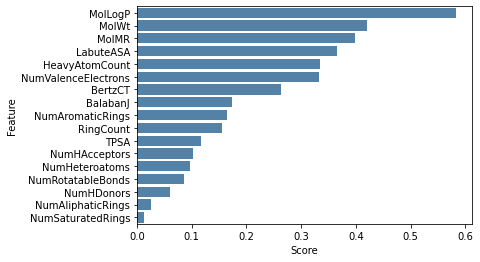

In [21]:
sns.barplot(data=scores_transposed, x='Score', y='Feature', color='steelblue')
# sns.set(rc = {'figure.figsize':(15,13)})
plt.savefig('solubility_features.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Unprocessed data and untuned models (only thing done is splitting data into training and test sets)

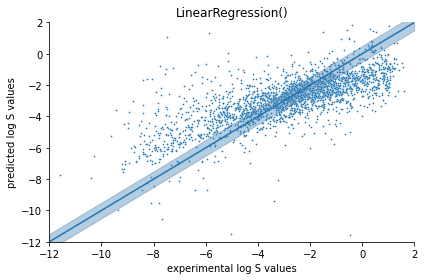

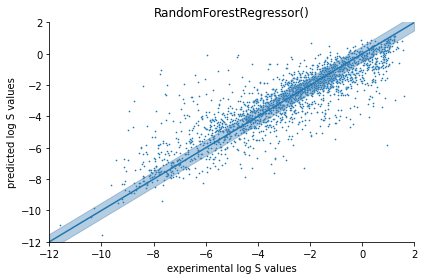

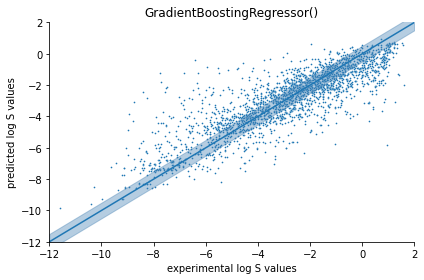

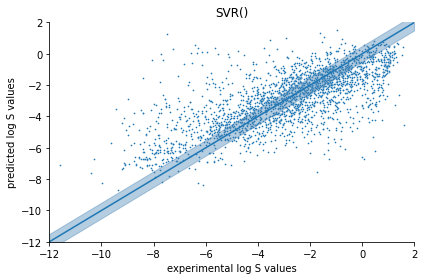

In [10]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
for regressor in regressors:
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))

    # plot scatter graphs of experimental values vs predicted values with x = y line
    sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within a +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    # aesthetic settings
    sns.despine()
    plt.tight_layout()
    
    # saving plots
    plt.savefig(f'{regressor}_solubility_test_set.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [56]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.519106,0.492611,1.701729
1,Random Forest Regressor,0.967148,0.766327,1.154846
2,Gradient Boosting Regressor,0.784518,0.726385,1.249654
3,Support Vector Regressor,0.535697,0.498251,1.692244


## Pre-processed data and untuned models

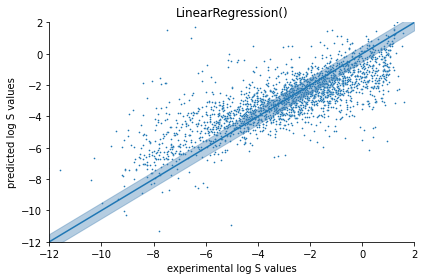

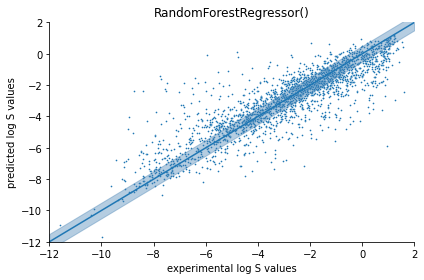

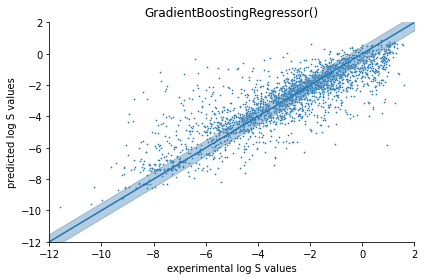

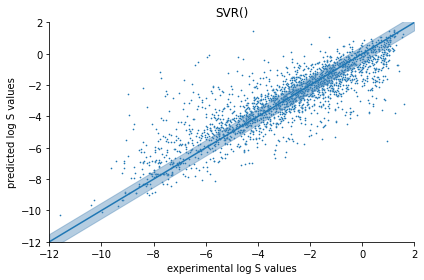

In [11]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
for regressor in regressors:
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('transformer', pt), ('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # plot scatter graphs of experimental values vs predicted values with x = y line
    ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log S values', ylabel='predicted log S values')

    # set axis limits to be the same
    plt.xlim(-12, 2)
    plt.ylim(-12, 2)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

    # shaded areas show values that lie within a +- 0.5 error zone
    exp_value = np.arange(-12, 3)
    upper_bound = exp_value + 0.5
    lower_bound = exp_value - 0.5
    plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
    
    # aesthetic settings
    sns.despine()
    plt.tight_layout()

    # saving plots
    plt.savefig(f'{regressor}_solubility_test_set_preprocessed.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [62]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.607152,0.576380,1.554919
1,Random Forest Regressor,0.967593,0.766389,1.154692
2,Gradient Boosting Regressor,0.784259,0.726244,1.249975
3,Support Vector Regressor,0.777291,0.741649,1.214297


## Preprocessed data and tuned hyperparameters

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 50, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 111}
0.935210052323031
0.7769329197403457
1.128333073816146


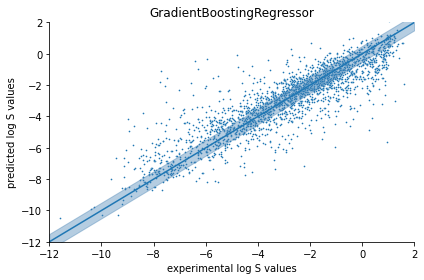

In [9]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__max_depth': [int(x) for x in np.linspace(1, 200, 10)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [int(x) for x in np.linspace(2, 50, 10)],
              'regressor__min_samples_split': [2, 4, 6],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', GradientBoostingRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='GradientBoostingRegressor', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within a +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('gbr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 133, 'regressor__bootstrap': False}
0.971670946355709
0.7778806055486505
1.1259336983076185


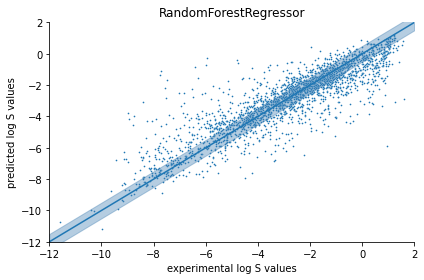

In [10]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__bootstrap': [True, False],
              'regressor__max_depth': [int(x) for x in np.linspace(1, 200, 10)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [int(x) for x in np.linspace(2, 50, 10)],
              'regressor__min_samples_split': [2, 4, 6],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='RandomForestRegressor', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within a +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('rfr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Fitting 30 folds for each of 80 candidates, totalling 2400 fits
{'regressor__C': 3, 'regressor__kernel': 'rbf', 'regressor__tol': 1e-06}
0.7972833365122668
0.7513064543983425
1.1913841939956848


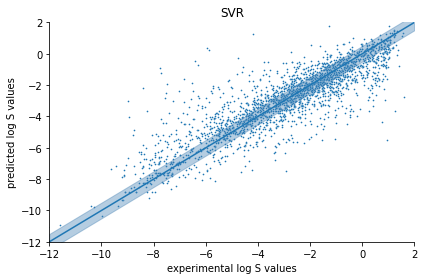

In [12]:
# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', SVR())])

# parameter grid containing hyperparameters to tune
param_grid = {'regressor__kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 
              'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6], 
              'regressor__C': [1, 1.5, 2, 2.5, 3]}

# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(pipeline, param_grid, cv=cvFold, verbose=2, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))

# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='SVR', xlabel='experimental log S values', ylabel='predicted log S values')

# set axis limits to be the same
plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within a +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('svr_solubility_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Random Forest Visualisation

In [9]:
# pipeline fitting and predicting using random forest regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=2, max_features='sqrt', max_depth=133, bootstrap=False))])
model = pipeline.fit(X_train, y_train)

# extract single tree
estimator = pipeline['regressor'].estimators_[0]

In [10]:
# export tree as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [13]:
# convert dot file to png
from subprocess import check_call
check_call(['dot','-Tpng','tree.dot','-o','tree.png','-Gdpi=1200'])

0

### Saving data for melting point predictions

In [30]:
# pipeline fitting and predicting using best regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=2, max_features='sqrt', max_depth=133, bootstrap=False))])
model = pipeline.fit(X_train, y_train)

In [31]:
# adding model predictions to original dataset so predictions can be matched to compound identifiers
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

In [32]:
# create dataframe of predicted and actual values
test_values = pd.DataFrame({'PredictedSolValues': test_predictions, 'ActualSolValues': y_test})
train_values = pd.DataFrame({'PredictedSolValues': train_predictions, 'ActualSolValues': y_train})
sol_values = pd.concat([test_values, train_values]).reset_index(drop=True)

In [33]:
test_values

,PredictedSolValues,ActualSolValues
420,-2.724871,-3.906401
843,-4.441145,-4.985758
5897,-0.461163,-0.500400
8331,-2.894043,-1.140000
6086,-1.481714,-1.561300
...,...,...
6403,-3.503384,-2.301700
8841,-3.113136,-3.130000
8088,-1.997288,-1.600000
2223,0.106608,0.618116


In [34]:
# adding the corresponding InChIKeys so values can be matched later on
key_train, key_test = train_test_split(df['InChIKey'], random_state=7)
inchikeys = pd.concat([key_test, key_train]).reset_index(drop=True)
sol_values['InChIKey'] = inchikeys

In [35]:
sol_values

,PredictedSolValues,ActualSolValues,InChIKey
0,-2.724871,-3.906401,YOVRNJUIHVNXCB-UHFFFAOYSA-N
1,-4.441145,-4.985758,NUPSHWCALHZGOV-UHFFFAOYSA-N
2,-0.461163,-0.500400,LKCWBDHBTVXHDL-RMDFUYIESA-N
3,-2.894043,-1.140000,GEUZJBMJDHYJEC-UHFFFAOYSA-N
4,-1.481714,-1.561300,AHHFEZNOXOZZQA-UHFFFAOYSA-N
...,...,...,...
9977,-3.838396,-4.193381,LWRBVKNFOYUCNP-UHFFFAOYSA-N
9978,-2.415409,-2.106000,SDIVYZXRQHWCKF-VIFPVBQESA-N
9979,-1.443514,-1.990100,CAHWDGJDQYAFHM-UHFFFAOYSA-N
9980,-2.606735,-2.830470,YTFVRYKNXDADBI-SNAWJCMRSA-N


In [36]:
sol_values.to_csv('best_sol_predictions.csv', index=False)